In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#!pip3 install parsedatetime
import parsedatetime
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binned_statistic
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import entropy
import warnings

In [2]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [3]:
warnings.filterwarnings("ignore")
df = pd.read_csv("./dataset1_log_files/dataset1/161.166.232.23/auth.log.anon", sep=']: ', names=['host','description'])
cases = ['Failed', 'Accepted']
cal = parsedatetime.Calendar()

In [4]:
rem = []
for i in df.index:
  if (
      ('port' not in str(df.loc[i]['description'])) 
      or ('pam_unix' in df.loc[i]['description']) 
      or ('XXXXX' not in df.loc[i]['description'])
      ):
    rem.append(i)

In [5]:
df = df.drop(index=rem)
df[['description', 'port']] = df['description'].str.split(' port ', 1, expand=True)
df[['description', 'ip']] = df['description'].str.split(' from ', 1, expand=True)
df['port'] = df['port'].str.split(' ssh2', 1, expand=True)
df[['host', 'sshd']] = df['host'].str.split(' sshd', 1, expand=True)
df['sshd'] = df['sshd'].str.split('[', 1, expand=True)[1]
df[['description','user']] = df['description'].str.split(' for ', 1, expand=True)
df['description'] = df['description'].str.split(' ', 1, expand=True)
df[['timestamp','host']] = df['host'].str.split(r"([0-9]+\.+[0-9]+\.+[0-9]+\.+[0-9]+)", 1, expand=True)[[0,1]]

In [6]:
t = []
for i in df.index:
  time_struct, parse_status = cal.parse(df['timestamp'][i])
  df.at[i,'timestamp'] = datetime(*time_struct[:6])
  if (df.loc[i]['user'] == 'XXXXX'):
    df.at[i,'user'] = 'valid'
  else:
    df.at[i,'user'] = 'invalid'
  if (df.loc[i]['description'] == 'Accepted'):
    t.append(1)
  else:
    t.append(0)

df['description'] = t

t = []
for i in df.index:
  if (df.loc[i]['user'] == 'valid'):
    t.append(1)
  else:
    t.append(0)

df['user'] = t

In [7]:
df.head(5)

,host,description,port,ip,sshd,user,timestamp
0,161.166.232.23,1,30658,95.177.77.244,7673,1,2021-11-25 01:10:33
3,161.166.232.23,0,20323,95.177.77.244,7734,0,2021-11-25 01:12:00
6,161.166.232.23,0,20323,95.177.77.244,7734,0,2021-11-25 01:12:01
8,161.166.232.23,0,46972,95.177.77.244,7767,1,2021-11-25 01:12:16
9,161.166.232.23,0,46972,95.177.77.244,7767,1,2021-11-25 01:12:35


In [8]:
print("Dataset shape:")
print(df.shape)
print("No of unique ip:")
print(df['ip'].nunique())
print("No of unique hosts:")
print(df['host'].nunique())
print("No of unique ports:")
print(df['port'].nunique())
print("No of unique sshd:")
print(df['sshd'].nunique())
print("No of successful attempts:")
print(df.loc[df['description']==1].shape[0])
print("No of unsuccessful attempts:")
print(df.loc[df['description']==0].shape[0])

Dataset shape:
(7331, 7)
No of unique ip:
112
No of unique hosts:
1
No of unique ports:
4644
No of unique sshd:
4671
No of successful attempts:
191
No of unsuccessful attempts:
7140


In [9]:
plt.rcParams['figure.figsize'] = [20,6]

Text(0.5, 1.0, 'Number of Login Attempts by IP')

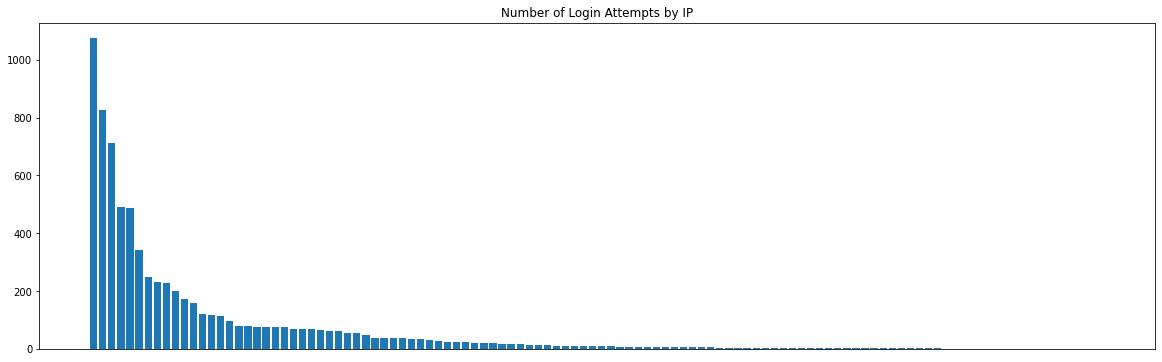

In [10]:
plt.bar(
    df['ip'].value_counts().index,
    df['ip'].value_counts().values)
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Number of Login Attempts by IP')

Text(0.5, 1.0, 'Number of Successful Login Attempts by IP')

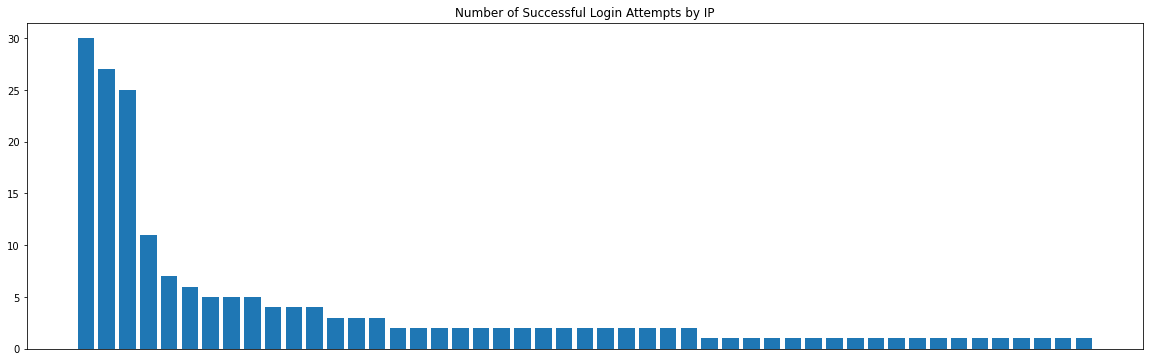

In [11]:
plt.bar(
    df.loc[df['description']==1]['ip'].value_counts().index,
    df.loc[df['description']==1]['ip'].value_counts().values)
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Number of Successful Login Attempts by IP')

Text(0.5, 1.0, 'Number of Successful Login Attempts by IP (excluding the most frequent)')

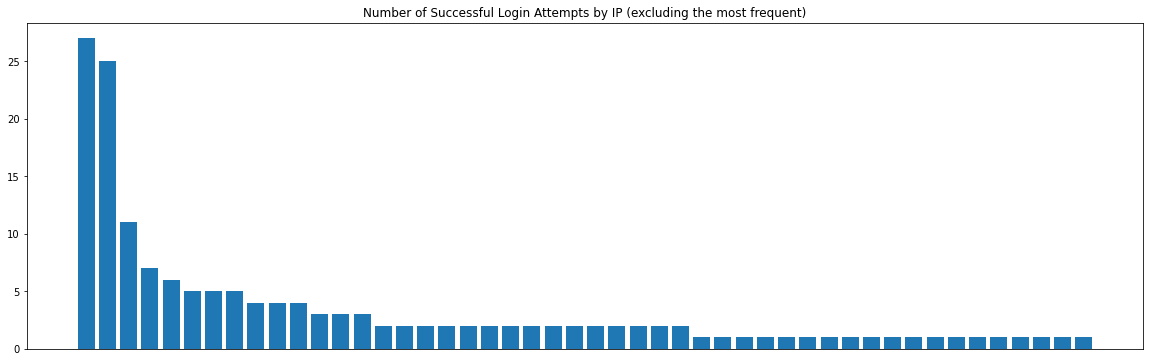

In [12]:
plt.bar(
    df.loc[df['description']==1]['ip'].value_counts().index[1:],
    df.loc[df['description']==1]['ip'].value_counts().values[1:])
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Number of Successful Login Attempts by IP (excluding the most frequent)')

Text(0.5, 1.0, 'Number of Failed Login Attempts by IP')

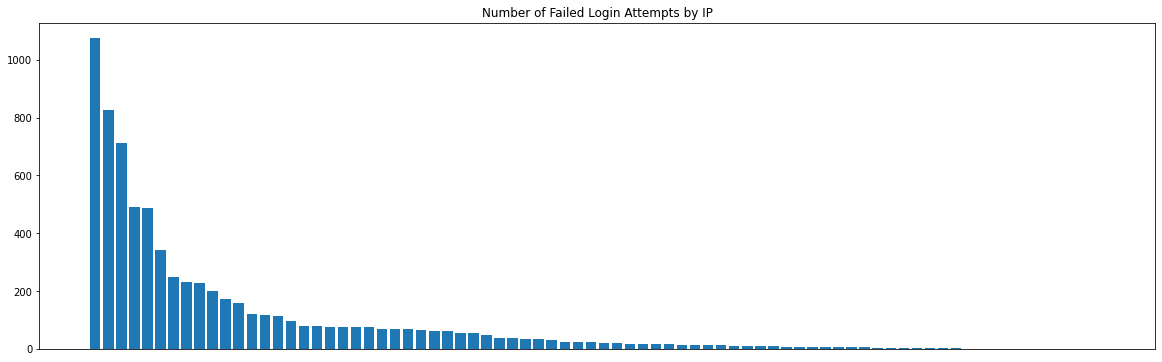

In [13]:
plt.bar(
    df.loc[df['description']==0]['ip'].value_counts().index,
    df.loc[df['description']==0]['ip'].value_counts().values)
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.title('Number of Failed Login Attempts by IP')

In [14]:
print("Top Number of Successful Login Attempts by IP")
print(df.loc[df['description']==1]['ip'].value_counts()[0:5])
print("\nTop Number of Failed Login Attempts by IP")
print(df.loc[df['description']==0]['ip'].value_counts()[0:5])

Top Number of Successful Login Attempts by IP
95.177.77.4       30
95.177.77.244     27
161.166.232.12    25
160.132.66.168    11
95.193.27.174      7
Name: ip, dtype: int64

Top Number of Failed Login Attempts by IP
161.166.232.19    1075
210.89.244.204     825
163.39.48.152      713
34.10.147.201      490
204.52.136.89      486
Name: ip, dtype: int64


Text(0.5, 1.0, 'Number of Login Attempts by IP Having The nth Most Failed Attempts')

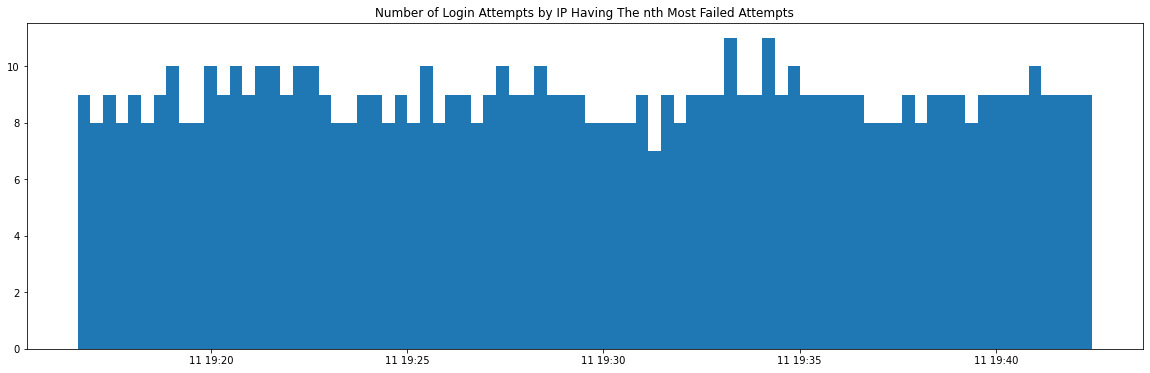

In [15]:
plt.hist(df.loc[df['ip']==df.loc[df['description']==0]['ip'].value_counts().index[2]]['timestamp'], bins=80)
plt.title('Number of Login Attempts by IP Having The nth Most Failed Attempts')

Text(0.5, 1.0, 'Number of Login Attempts by IP Having The nth Most Successful Attempts')

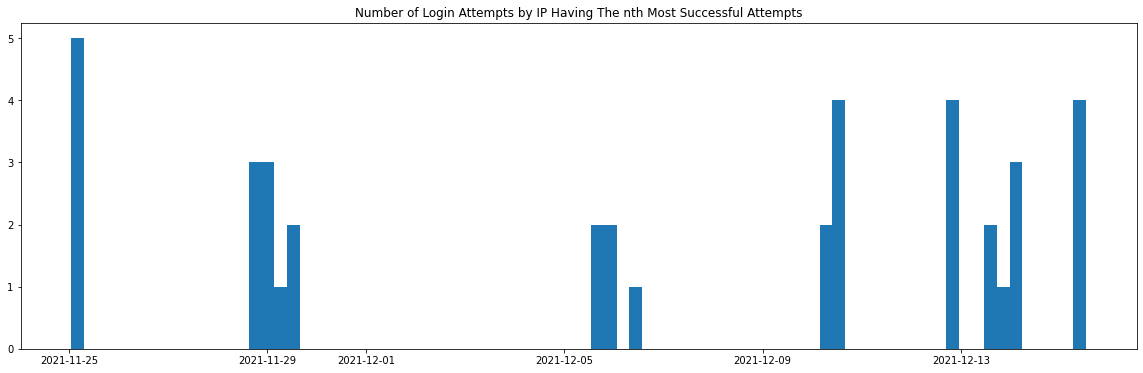

In [16]:
plt.hist(df.loc[df['ip']==df.loc[df['description']==1]['ip'].value_counts().index[1]]['timestamp'], bins=80)
plt.title('Number of Login Attempts by IP Having The nth Most Successful Attempts')

In [17]:
print(df['ip'].unique().shape)
print(df.shape)

(112,)
(7331, 7)


In [18]:
ip = df['ip'].unique()
accepted = []
failed = []
user_invalid = []
user_valid = []
std = []
mean = []
duration = []
pswden = []
useren = []

In [19]:
for i in ip:
  accepted.append(df.loc[df['ip']==i].loc[df['description']==1].shape[0])
  failed.append(df.loc[df['ip']==i].loc[df['description']==0].shape[0])
  en = entropy(df['description'].loc[df['ip']==i].values, base=2)
  if (np.isnan(en)): en = 100
  pswden.append(sigmoid(en))
  
  user_invalid.append(df.loc[df['ip']==i].loc[df['user']==0].shape[0])
  user_valid.append(df.loc[df['ip']==i].loc[df['user']==1].shape[0])
  en = entropy(df['user'].loc[df['ip']==i].values, base=2)
  if (np.isnan(en)): en = 100
  useren.append(sigmoid(en))
  
  timedef = df.loc[df['ip']==i].timestamp.values
  dr = timedef[timedef.shape[0] - 1] - timedef[0]
  duration.append(dr.total_seconds()/86400)

  data = np.array([j.timestamp() for j in df.loc[df['ip']==i]['timestamp']])
  bin_means = binned_statistic(data, data, bins=80, range=(data.min(), data.max()))[0]
  bin_means[np.isnan(bin_means)] = 0

  mean.append(np.mean(bin_means))
  std.append(np.std(bin_means))

dfip = pd.DataFrame()
dfip['accepted'] = accepted
dfip['failed'] = failed
dfip['user_invalid'] = user_invalid
dfip['user_valid'] = user_valid
dfip['mean'] = mean
dfip['std'] = std
dfip['duration'] = duration
dfip['useren'] = useren
dfip['pswden'] = pswden
dfip = dfip.set_index(ip)

In [20]:
dfip.sort_values(by=["failed"], ascending=False)

,accepted,failed,user_invalid,user_valid,mean,std,duration,useren,pswden
161.166.232.19,0,1075,546,529,9.223437e+08,8.134307e+08,0.004641,0.999882,1.000000
210.89.244.204,0,825,255,570,1.638926e+09,9.041118e+02,0.036250,0.999894,1.000000
163.39.48.152,0,713,99,614,1.639231e+09,4.477568e+02,0.017951,0.999905,1.000000
34.10.147.201,0,490,152,338,1.638954e+09,4.869013e+02,0.019525,0.999775,1.000000
204.52.136.89,0,486,0,486,1.638785e+09,9.742751e+02,0.039016,0.999867,1.000000
...,...,...,...,...,...,...,...,...,...
160.132.75.33,1,0,0,1,2.048373e+07,1.820634e+08,0.000000,0.500000,0.500000
160.132.66.168,11,0,0,11,1.638706e+08,4.916118e+08,0.160301,0.969511,0.969511
160.132.109.165,2,0,0,2,4.096742e+07,2.558415e+08,0.037581,0.731059,0.731059
160.132.94.104,1,0,0,1,2.048356e+07,1.820618e+08,0.000000,0.500000,0.500000


In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dfip.values)
dfip = pd.DataFrame(data = x_scaled, columns = dfip.columns)

In [22]:
dfip

,accepted,failed,user_invalid,user_valid,mean,std,duration,useren,pswden
0,0.900000,0.011163,0.003663,0.060261,0.177105,0.781253,1.000000,0.989130,0.982928
1,0.066667,0.000000,0.000000,0.003257,0.012642,0.312333,0.000180,0.462117,0.462117
2,0.066667,0.000000,0.000000,0.003257,0.012642,0.312333,0.000014,0.462117,0.462117
3,0.166667,0.000000,0.000000,0.008143,0.050571,0.484253,0.004595,0.821354,0.821354
4,0.133333,0.000000,0.000000,0.006515,0.037928,0.436006,0.000296,0.761594,0.761594
...,...,...,...,...,...,...,...,...,...
107,0.000000,0.002791,0.001832,0.003257,0.025332,0.380536,0.000003,0.462117,1.000000
108,0.000000,0.044651,0.000000,0.078176,0.582318,0.986044,0.000067,0.992520,1.000000
109,0.033333,0.032558,0.025641,0.035831,0.443074,0.996486,0.000109,0.977127,0.000000
110,0.000000,0.056744,0.000000,0.099349,0.734235,0.881319,0.000087,0.994701,1.000000


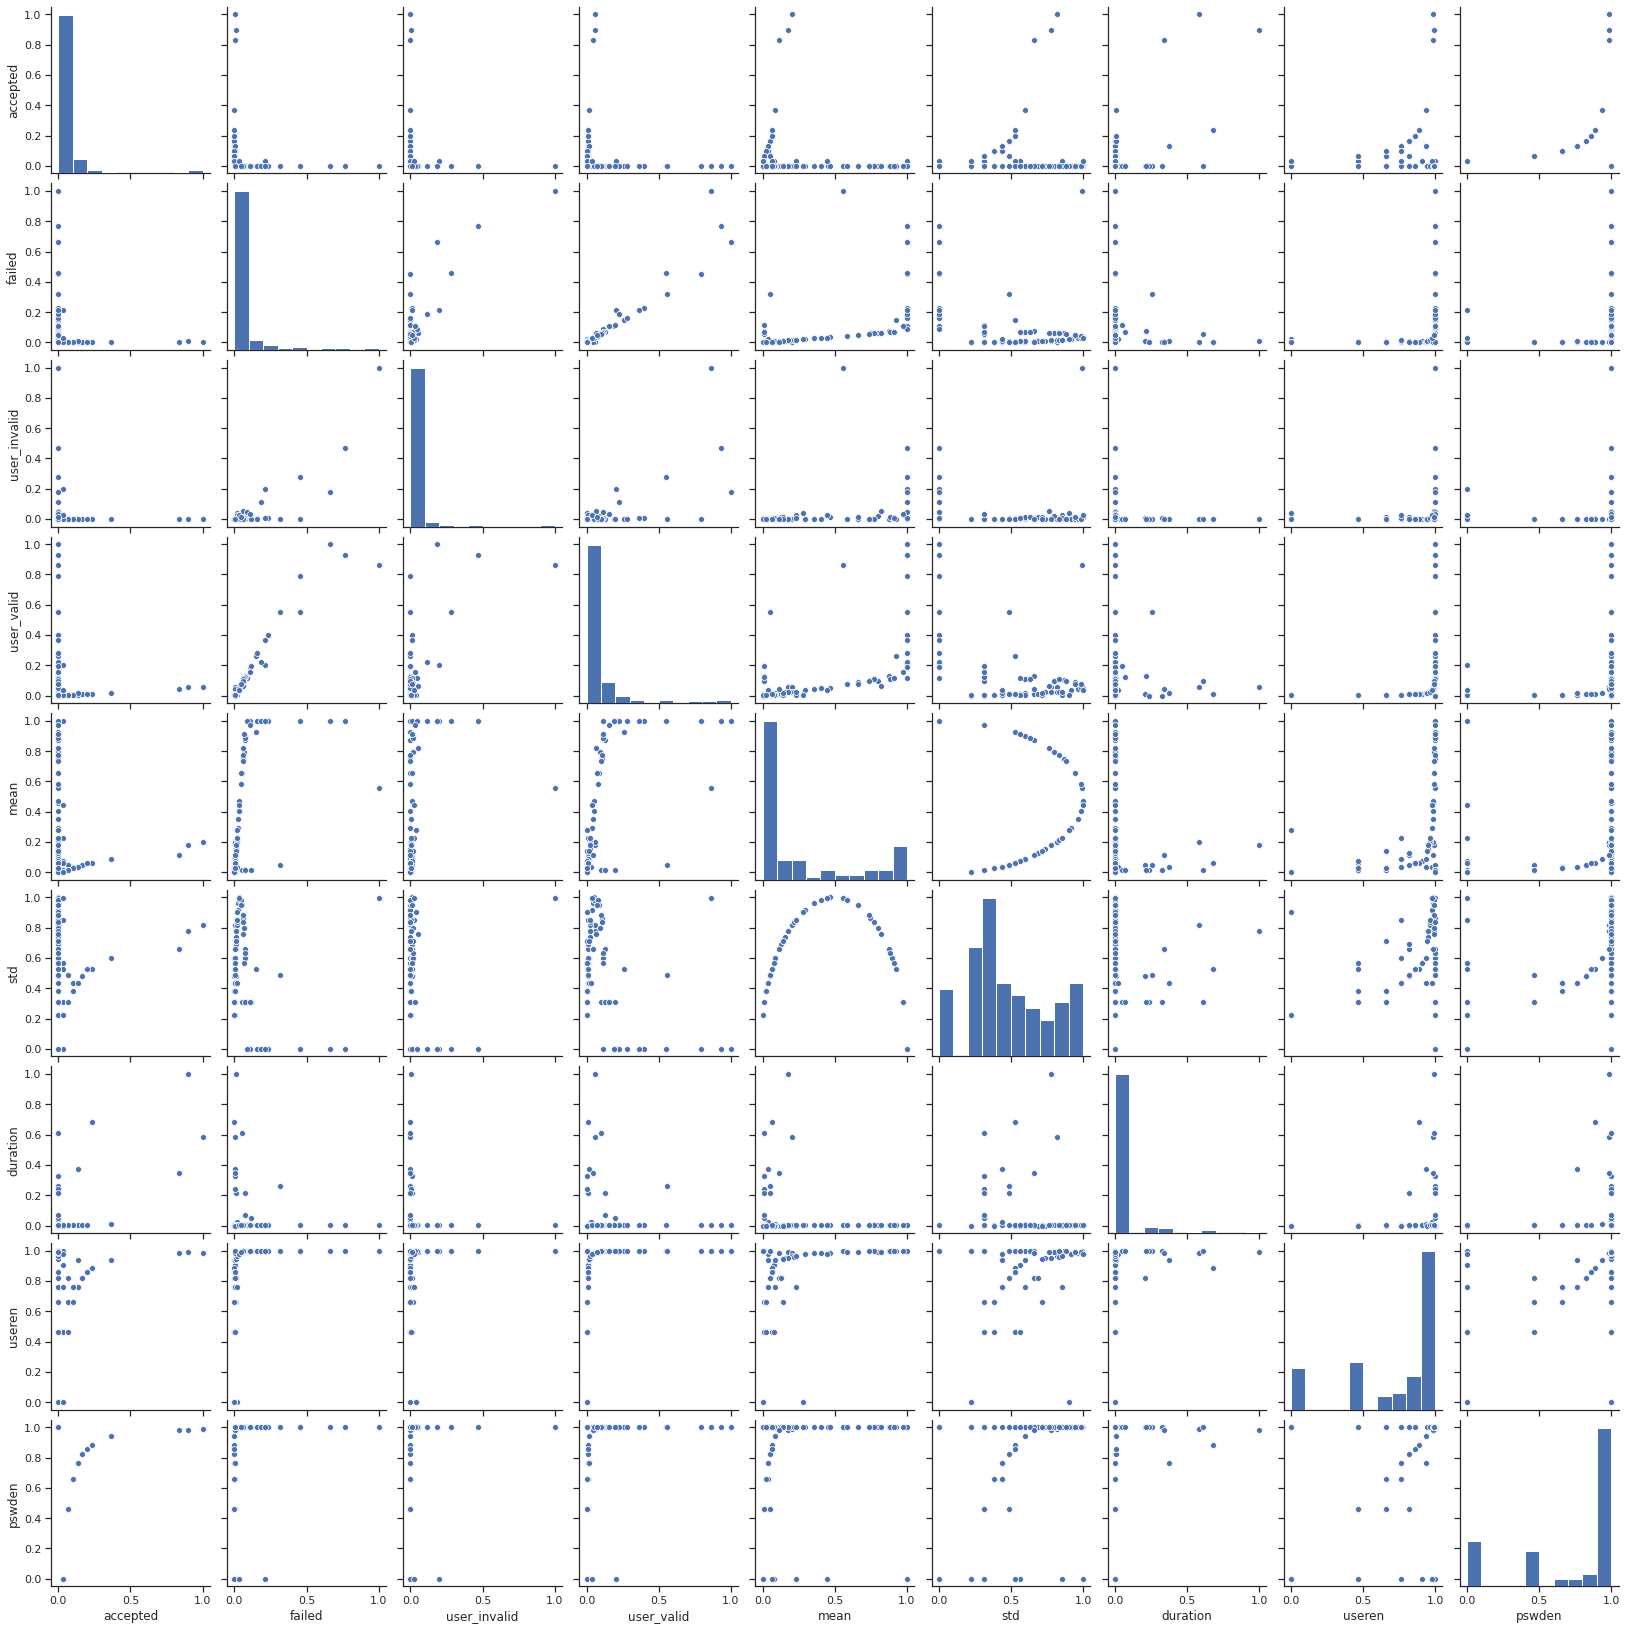

In [23]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(dfip)
# g._legend.remove()
plt.show()

<AxesSubplot:>

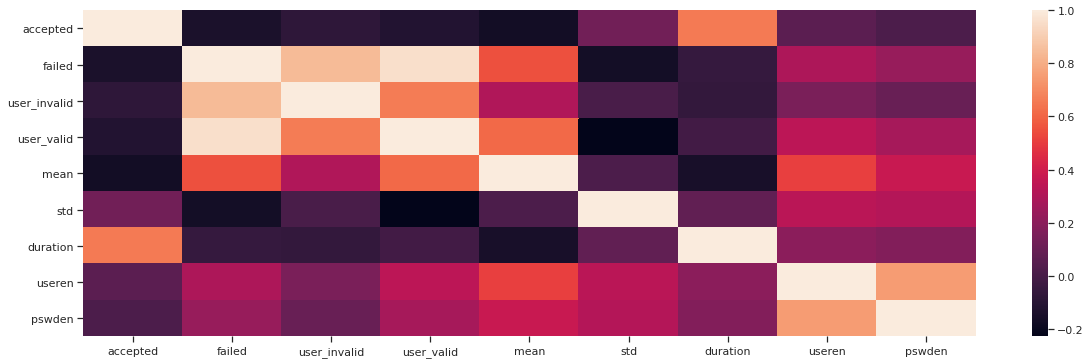

In [24]:
sns.heatmap(dfip.corr())

AttributeError: 'PairGrid' object has no attribute '_legend'

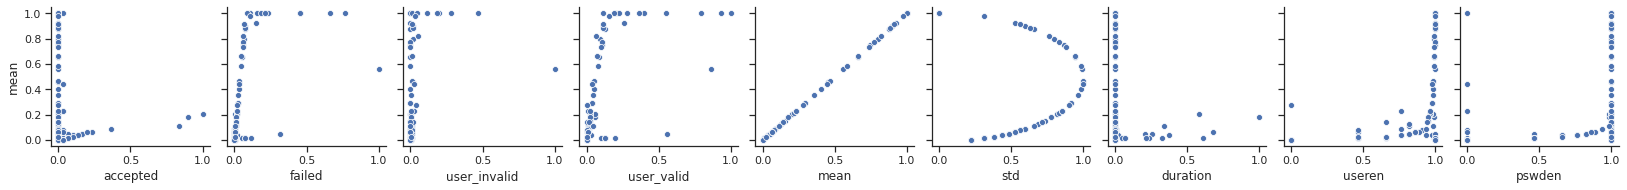

In [26]:
g = sns.pairplot(dfip, y_vars=['mean'], x_vars=dfip.columns)
g._legend.remove()
plt.show()